<a href="https://colab.research.google.com/github/niikun/DL_for_health_care/blob/main/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW1
## Overview
データを準備し、基本的な統計量を計算し、簡単なモデルを構築することは、データサイエンスの実践に不可欠なステップです。この宿題では、心不全予測を実行するための生の入力として臨床データを使用します。この宿題ではPythonプログラミングが必要です。プログラミング問題のスタートポイントとして、添付のスケルトンコードを参照してください。

この宿題はPandasに精通していることを前提としています。Pandasのクラッシュコースが必要な場合は、100 Pandas Puzzlesに取り組むことをお勧めします。

```python
import pandas as pd
import numpy as np
import base64

df1 = pd.read_csv("PATH/event_feature_map.csv")
df2 = pd.read_csv("PATH/events.csv")
df3 = pd.read_csv("PATH/hf_events.csv")
df1.to_csv("event_feature_map.csv")
df2.to_csv("events.csv")
df3.to_csv("hf_events.csv")

from IPython.display import HTML

def create_download_link(df, title="Download CSV file", filename="processed_file.csv"):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()  # CSVをbase64エンコード
    href = f'<a href="data:file/csv;base64,{b64}" download="{filename}">{title}</a>'
    return HTML(href)

# ダウンロードリンクの表示
create_download_link(df3)
```

## About Raw Data
この宿題では、[MIMIC-III](https://www.nature.com/articles/sdata201635)から合成した臨床データセットを使用する。
https://www.nature.com/articles/sdata201635

**events.csv**  
events.csvで提供されるデータは、イベント・シーケンスである。このファイルの各行は、(pid, event_id, vid, value)という形式のタプルで構成されています。

例えば  

```
33,DIAG_244,0,1
33,DIAG_414,0,1
33,DIAG_427,0,1
33,LAB_50971,0,1
33,LAB_50931,0,1
33,LAB_50812,1,1
33,DIAG_425,1,1
33,DIAG_427,1,1
33,DRUG_0,1,1
33,DRUG_3,1,1
```
- pid： 非特定患者ID。例えば、上の例の患者のpidは33である。
- event_id： 臨床イベント識別子。例えば、DIAG_244 は、患者が ICD9 コード 244 で病気と診断されたことを意味し、LAB_50971 は、コード 50971 の臨床検査が患者に実施されたことを意味し、DRUG_0 は、コード 0 の薬剤が患者に処方されたことを意味する。対応する検査（薬）名は`{DATA_PATH}/lab_list.txt` `{DATA_PATH}/drug_list.txt`）にある。
- vid：来院識別子。例えば、患者には合計2回の来院がある。vidは序数であることに注意。つまり、vidが大きい診察はvidが小さい診察の後に行われる。
- value： イベントに関連づけられた値（合成されたデータセットでは常に1）．

**hf_events.csv**  
*hf_events.csv*で提供されるデータには、少なくとも1回の診察で心不全（すなわち、DIAG_398、DIAG_402、DIAG_404、DIAG_428）と診断された患者のpidが含まれている。これらは*(pid, vid, label)*の書式を持つタプルの形式である。例えば

```
156,0,1
181,1,1
```

vidはその患者の心不全を伴う初診のインデックスを示し、1のラベルは心不全の存在を示す。**このファイルには心不全患者のみが含まれる。このファイルに記載されていない患者は心不全と診断されたことがない。

**event_feature_map.csv**  
event_feature_map.csv は、event_id から整数インデックスへのマップである。このファイルには、すべてのイベントIDの(idx, event_id)のペアが含まれる。

In [1]:
import time
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
events = pd.read_csv('/content/drive/MyDrive/coursera/Deep Learning for Healthcare/events.csv')
hf = pd.read_csv('/content/drive/MyDrive/coursera/Deep Learning for Healthcare/hf_events.csv')
feature_map = pd.read_csv("/content/drive/MyDrive/coursera/Deep Learning for Healthcare/event_feature_map.csv")

In [3]:
events.head()

,pid,event_id,vid,value
0,33,DIAG_244,0,1
1,33,DIAG_414,0,1
2,33,DIAG_427,0,1
3,33,DIAG_585,0,1
4,33,DIAG_V45,0,1


In [4]:
hf.head()

,pid,vid,label
0,33,0,1
1,64,0,1
2,156,0,1
3,181,1,1
4,199,1,1


In [5]:
feature_map.head()

,idx,event_id
0,0,DIAG_003
1,1,DIAG_004
2,2,DIAG_005
3,3,DIAG_007
4,4,DIAG_008


In [6]:
events[events['event_id']=="DIAG_007"]

,pid,event_id,vid,value
679512,99492,DIAG_007,0,1
679568,99492,DIAG_007,1,1


## Descriptive Statistics  
分析モデリングを始める前に、入力された生データの記述統計量を取得することは良い習慣です。この問題では、前述のデータに対して様々なメトリクスを計算するコードを書く必要があります。出発点として、スケルトン・コードを提供します。

結果表で使用される用語の定義を以下に示します：

- **Event count**：  特定の患者について記録されたイベントの数。
- **Encounter count**： 所定の患者について記録された訪問回数。   
入力ファイルの各行はイベントであり、各来院は複数のイベントで構成されていることに注意。

以下のコード・セルを完成させて、必要な統計を実装してください。  

ファイル名や既存の関数宣言を変更することはできません。pythonのnumpy、scipy、scikit-learn、pandas、その他の組み込みモジュールのみが使用可能です。pandasライブラリの使用を推奨します。

TODO : イベント数のメトリクスを返すために、この関数を実装します。
    
event_countは、指定された患者について記録されたイベントの数として定義されます。  
    avg_hf_event_count = None  
    max_hf_event_count = None  
    min_hf_event_count = None  
    avg_norm_event_count = None  
    max_norm_event_count = None  
    min_norm_event_count = None  

In [7]:
hf.head()

,pid,vid,label
0,33,0,1
1,64,0,1
2,156,0,1
3,181,1,1
4,199,1,1


In [8]:
events.head()

,pid,event_id,vid,value
0,33,DIAG_244,0,1
1,33,DIAG_414,0,1
2,33,DIAG_427,0,1
3,33,DIAG_585,0,1
4,33,DIAG_V45,0,1


In [9]:
events.groupby("pid")["event_id"].count()

pid
33       122
64       132
78       209
156      187
181      165
        ... 
99788    107
99800    161
99825    238
99841    192
99971    143
Name: event_id, Length: 4000, dtype: int64

<Axes: xlabel='event_id', ylabel='Count'>

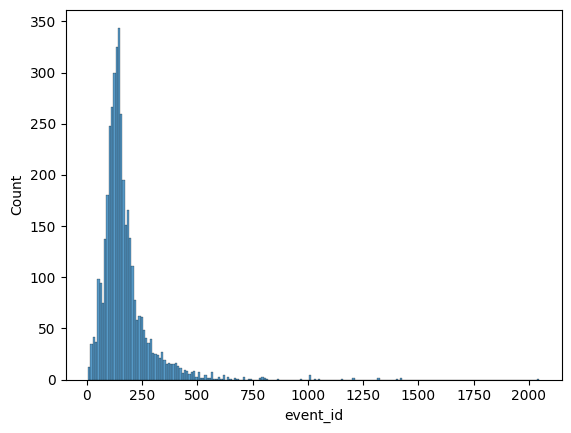

In [10]:
sns.histplot(events.groupby("pid")["event_id"].count())

In [11]:
 avg_norm_event_count = events.groupby("pid")["event_id"].count().mean()
 max_norm_event_count = events.groupby("pid")["event_id"].count().max()
 min_norm_event_count = events.groupby("pid")["event_id"].count().min()
 print(avg_norm_event_count)
 print(max_norm_event_count)
 print(min_norm_event_count)

170.66125
2046
6


In [12]:
print(hf.shape,events.shape)

(2960, 3) (682645, 4)


In [13]:
df_hf_events = pd.merge(hf, events, on="pid",how="left")
df_hf_events.head()

,pid,vid_x,label,event_id,vid_y,value
0,33,0,1,DIAG_244,0,1
1,33,0,1,DIAG_414,0,1
2,33,0,1,DIAG_427,0,1
3,33,0,1,DIAG_585,0,1
4,33,0,1,DIAG_V45,0,1


In [14]:
((df_hf_events["vid_x"] != df_hf_events["vid_y"]).sum()-df_hf_events.shape[0])/-df_hf_events.shape[0]

0.3599252577089163

In [15]:
df_hf_events.groupby("pid")["event_id"].count()

pid
33       122
64       132
156      187
181      165
199      572
        ... 
99784    222
99788    107
99825    238
99841    192
99971    143
Name: event_id, Length: 2960, dtype: int64

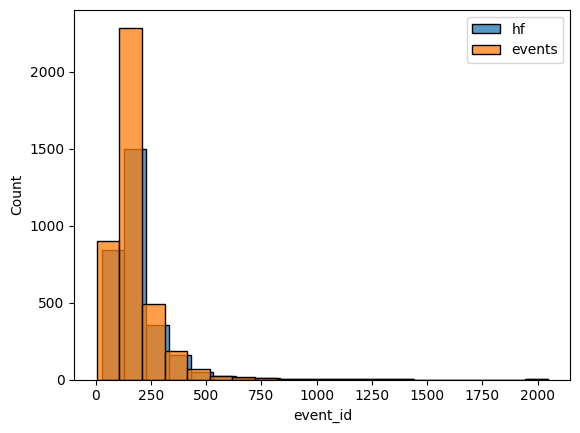

In [16]:
sns.histplot(df_hf_events.groupby("pid")["event_id"].count(),bins=20,label="hf")
sns.histplot(events.groupby("pid")["event_id"].count(),bins=20,label="events")
plt.legend()
plt.show()

In [17]:
 avg_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().mean()
 max_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().max()
 min_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().min()
 print(avg_hf_event_count)
 print(max_hf_event_count)
 print(min_hf_event_count)

188.9375
2046
28


In [18]:
def event_count_metrics(events, hf):

    '''
    TODO : Implement this function to return the event count metrics.

    Event count is defined as the number of events recorded for a given patient.
    '''
    df_hf_events = pd.merge(hf, events, on="pid",how="left")
    hf_pids = set(hf['pid'].unique())
    non_hf_events = events[~events['pid'].isin(hf_pids)]

    avg_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().mean()
    max_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().max()
    min_hf_event_count = df_hf_events.groupby("pid")["event_id"].count().min()
    avg_norm_event_count = non_hf_events.groupby("pid")["event_id"].count().mean()
    max_norm_event_count = non_hf_events.groupby("pid")["event_id"].count().max()
    min_norm_event_count = non_hf_events.groupby("pid")["event_id"].count().min()

    # your code here
#     raise NotImplementedError

    return avg_hf_event_count, max_hf_event_count, min_hf_event_count, \
           avg_norm_event_count, max_norm_event_count, min_norm_event_count

In [19]:
event_count_metrics(events, hf)

(188.9375, 2046, 28, 118.64423076923077, 1014, 6)

In [20]:
 avg_hf_encounter_count = df_hf_events.groupby(["pid","vid_y"])["value"].count().mean()
 max_hf_encounter_count = df_hf_events.groupby(["pid","vid_y"])["value"].count().max()
 min_hf_encounter_count = df_hf_events.groupby(["pid","vid_y"])["value"].count().min()
 print(avg_hf_encounter_count)
 print(min_hf_encounter_count)
 print(max_hf_encounter_count)
 avg_norm_encounter_count = events.groupby(["pid","vid"])["value"].count().mean()
 max_norm_encounter_count = events.groupby(["pid","vid"])["value"].count().max()
 min_norm_encounter_count = events.groupby(["pid","vid"])["value"].count().min()
 print(avg_norm_encounter_count)
 print(max_norm_encounter_count)
 print(min_norm_encounter_count)

67.33144714664098
1
180
64.50392138335066
180
1


## ここがポイント‼‼‼‼
hf 以外の人の集計をする必要がある

In [21]:
hf['pid'].unique()

array([   33,    64,   156, ..., 99825, 99841, 99971])

In [22]:
hf_pids = set(hf['pid'].unique())

In [23]:
events.head()

,pid,event_id,vid,value
0,33,DIAG_244,0,1
1,33,DIAG_414,0,1
2,33,DIAG_427,0,1
3,33,DIAG_585,0,1
4,33,DIAG_V45,0,1


In [24]:
events['pid'].isin(hf_pids)

0         True
1         True
2         True
3         True
4         True
          ... 
682640    True
682641    True
682642    True
682643    True
682644    True
Name: pid, Length: 682645, dtype: bool

In [25]:
events[~events['pid'].isin(hf_pids)]

,pid,event_id,vid,value
254,78,DIAG_278,0,1
255,78,DIAG_285,0,1
256,78,DIAG_300,0,1
257,78,DIAG_311,0,1
258,78,DIAG_338,0,1
...,...,...,...,...
682067,99800,DRUG_0,1,1
682068,99800,DRUG_164,1,1
682069,99800,DRUG_28,1,1
682070,99800,DRUG_18,1,1


In [26]:
non_hf_events = events[~events['pid'].isin(hf_pids)]

In [27]:
non_hf_events.groupby("pid")["event_id"].count().mean()

118.64423076923077

In [28]:
def encounter_count_metrics(events, hf):

    '''
    TODO : Implement this function to return the encounter count metrics.

    Encounter count is defined as the number of visits recorded for a given patient.
    '''

    df_hf_events = pd.merge(hf, events, on="pid", how="left")
    hf_pids = set(hf['pid'].unique())
    non_hf_events = events[~events['pid'].isin(hf_pids)]

    hf_encounter_counts = df_hf_events.groupby("pid")["vid_y"].nunique()
    norm_encounter_counts = non_hf_events.groupby("pid")["vid"].nunique()

    avg_hf_encounter_count = hf_encounter_counts.mean()
    max_hf_encounter_count = hf_encounter_counts.max()
    min_hf_encounter_count = hf_encounter_counts.min()
    avg_norm_encounter_count = norm_encounter_counts.mean()
    max_norm_encounter_count = norm_encounter_counts.max()
    min_norm_encounter_count = norm_encounter_counts.min()

    # your code here
#     raise NotImplementedError

    return avg_hf_encounter_count, max_hf_encounter_count, min_hf_encounter_count, \
           avg_norm_encounter_count, max_norm_encounter_count, min_norm_encounter_count

In [29]:
encounter_count_metrics(events, hf)

(2.8060810810810812, 34, 2, 2.189423076923077, 11, 1)

## 2 Feature construction
実際の機械学習モデルを実行する前に、生データを標準的なデータ形式に変換することは一般的なプラクティスです。この問題では、このスクリプトに必要なpython関数を実装します。TRAIN_DATA_PATHフォルダにあるevents.csv、hf_events.csv、event_feature_map.csvファイルを使用します。この問題ではpandasライブラリの使用を推奨します。

以下に、フィーチャ構築を始める前に知っておくべきいくつかの概念を示します（詳細は講義を参照してください）。

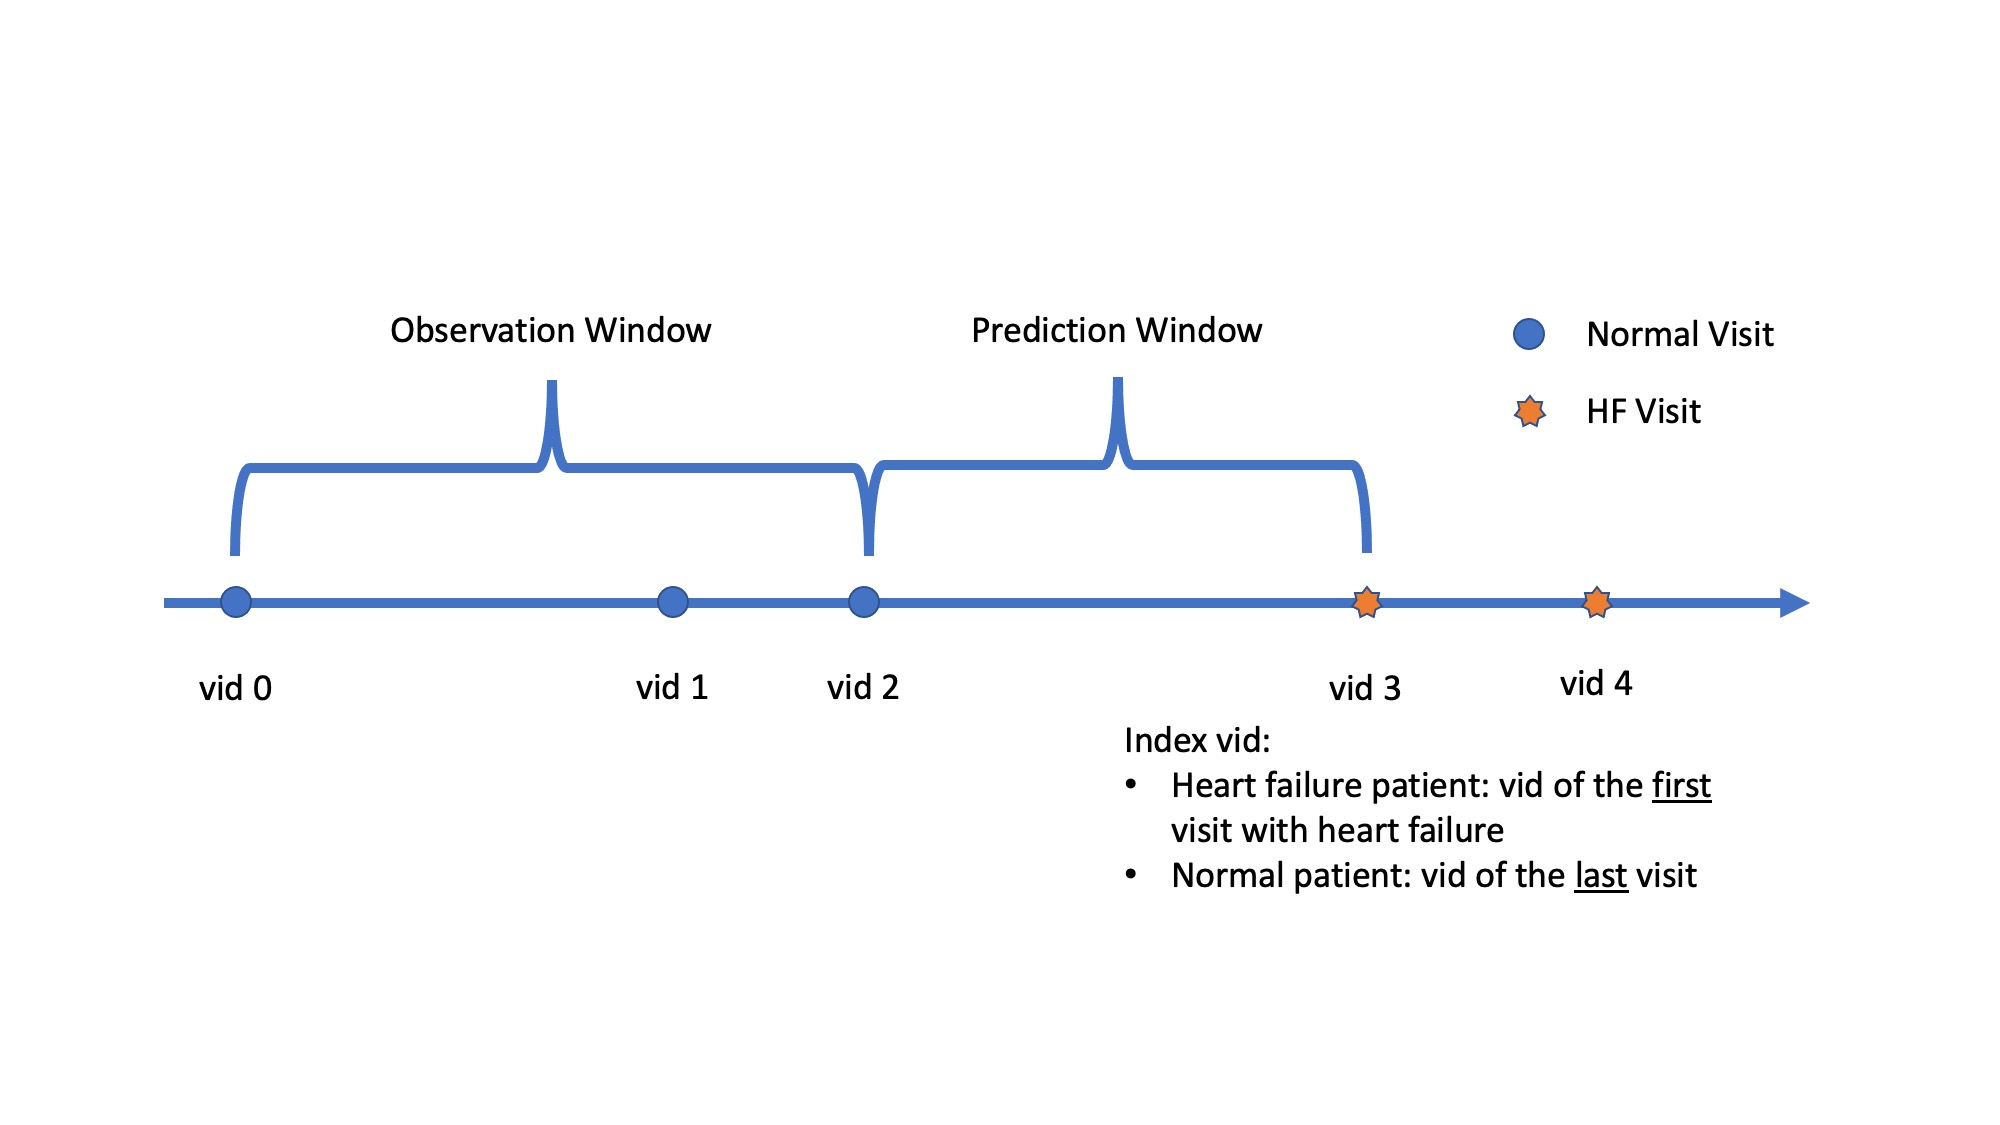

- インデックスvid： Index vidは以下のように評価される：
  - 心不全患者の場合： インデックスvidは、その患者の心不全による初診日のvidとする(すなわち、hf_events.csvのvidフィールド)。
  - 正常患者： インデックス vid は、その患者の最後の診察の vid(すなわち、events.csv の vid フィールド)。
- 観察ウィンドウ： 関連イベントの識別に使用する時間間隔。特徴ベクトルを構築する際には、このウィンドウに存在するイベントのみを含める必要があります。
- 予測ウィンドウ： 予測に使用する固定時間間隔。
上の例では、インデックスvidは3であり、vid 0, 1, 2の訪問は観察ウィンドウ内にある。予測ウィンドウは訪問2と3の間にある。

### 2-1 Compute the index vid
上記の定義を使用して、すべての患者のインデックス vid を計算します。以下のコード・セルにある read_csv メソッドおよび calculate_index_vid メソッドを完了します。

In [30]:
# import pandas as pd
# import datetime


# def read_csv(filepath=TRAIN_DATA_PATH):

#     '''
#     Read the events.csv, hf_events.csv and event_feature_map.csv files.

#     NOTE: remember to use `filepath` whose default value is `TRAIN_DATA_PATH`.
#     '''

#     events = pd.read_csv(filepath + 'events.csv')
#     hf = pd.read_csv(filepath + 'hf_events.csv')
#     feature_map = pd.read_csv(filepath + 'event_feature_map.csv')

#     return events, hf, feature_map

### TODO: この関数を完成させる必要がある。  
推奨されるステップ  
1. 正常患者のリストを作成します (hf_events.csv は心不全患者に関する情報のみを含みます)。
2. 患者が心不全であるかどうかに基づいて、イベントを 2 つのグループに分割する。
3. 各患者の index vid を計算する。
    
**重要：**
indx_vid` はヘッダ `['pid', 'indx_vid']` を持つ pd dataframe でなければならない。

In [31]:

def calculate_index_vid(events, hf):

    '''
    TODO: This function needs to be completed.

    Suggested steps:
        1. Create list of normal patients (hf_events.csv only contains information about heart failure patients).
        2. Split events into two groups based on whether the patient has heart failure or not.
        3. Calculate index vid for each patient.

    IMPORTANT:
        `indx_vid` should be a pd dataframe with header `['pid', 'indx_vid']`.
    '''

    indx_vid = ''

    # your code here
    raise NotImplementedError

    return indx_vid

正常患者のリストを作成します (hf_events.csv は心不全患者に関する情報のみを含みます)。

In [32]:
events.head()

,pid,event_id,vid,value
0,33,DIAG_244,0,1
1,33,DIAG_414,0,1
2,33,DIAG_427,0,1
3,33,DIAG_585,0,1
4,33,DIAG_V45,0,1


In [33]:
hf.head()

,pid,vid,label
0,33,0,1
1,64,0,1
2,156,0,1
3,181,1,1
4,199,1,1


In [34]:
feature_map.head()

,idx,event_id
0,0,DIAG_003
1,1,DIAG_004
2,2,DIAG_005
3,3,DIAG_007
4,4,DIAG_008


In [35]:
events_hf = events[events["pid"].isin(set(hf["pid"].unique()))]

In [36]:
events_norm = events[~events["pid"].isin(set(hf["pid"].unique()))]

In [37]:
events.shape

(682645, 4)

In [38]:
events_hf.shape, events_norm.shape,events_hf.shape[0]+events_norm.shape[0]

((559255, 4), (123390, 4), 682645)

In [39]:
events_hf.head()

,pid,event_id,vid,value
0,33,DIAG_244,0,1
1,33,DIAG_414,0,1
2,33,DIAG_427,0,1
3,33,DIAG_585,0,1
4,33,DIAG_V45,0,1


In [40]:
events_norm[events_norm["pid"]==78]

,pid,event_id,vid,value
254,78,DIAG_278,0,1
255,78,DIAG_285,0,1
256,78,DIAG_300,0,1
257,78,DIAG_311,0,1
258,78,DIAG_338,0,1
...,...,...,...,...
458,78,DRUG_254,1,1
459,78,DRUG_423,1,1
460,78,DRUG_105,1,1
461,78,DRUG_340,1,1


インデックスvid： Index vidは以下のように評価される：  
- 心不全患者の場合： インデックスvidは、その患者の心不全による初診日のvidとする(すなわち、hf_events.csvのvidフィールド)。
- 正常患者： インデックス vid は、その患者の最後の診察の vid(すなわち、events.csv の vid フィールド)。

In [41]:
pid_indx_vid_norm = pd.DataFrame(events_norm.groupby("pid")["vid"].max()).reset_index()
pid_indx_vid_norm

,pid,vid
0,78,1
1,190,1
2,333,1
3,695,1
4,701,1
...,...,...
1035,99102,1
1036,99381,1
1037,99586,1
1038,99729,1


In [42]:
pid_indx_vid_hf = pd.DataFrame(events_hf.groupby("pid")["vid"].min()).reset_index()
pid_indx_vid_hf

,pid,vid
0,33,0
1,64,0
2,156,0
3,181,0
4,199,0
...,...,...
2955,99784,0
2956,99788,0
2957,99825,0
2958,99841,0


In [43]:
pid_indx_vid_all = pd.concat([pid_indx_vid_hf,pid_indx_vid_norm],axis=0).reset_index(drop=True)
pid_indx_vid_all.shape

(4000, 2)

In [44]:
def calculate_index_vid(events, hf):

    '''
    TODO: This function needs to be completed.

    Suggested steps:
        1. Create list of normal patients (hf_events.csv only contains information about heart failure patients).
        2. Split events into two groups based on whether the patient has heart failure or not.
        3. Calculate index vid for each patient.

    IMPORTANT:
        `indx_vid` should be a pd dataframe with header `['pid', 'indx_vid']`.
    '''

    # 1. Create list of normal patients
    hf_patients = set(hf["pid"].unique())

    # 2. Split events into two groups based on whether the patient has heart failure or not
    events_hf = events[events["pid"].isin(hf_patients)]
    events_norm = events[~events["pid"].isin(hf_patients)]

    # 3. Calculate index vid for each patient
    # For heart failure patients, use the minimum vid from hf_events
    indx_vid_hf = hf.groupby("pid")["vid"].min().reset_index()

    # For normal patients, use the maximum vid from events
    indx_vid_norm = events_norm.groupby("pid")["vid"].max().reset_index()

    # Combine the results
    indx_vid = pd.concat([indx_vid_hf, indx_vid_norm], axis=0).reset_index(drop=True)
    indx_vid.columns = ["pid", "indx_vid"]

    return indx_vid

In [45]:
indx_vid_df = calculate_index_vid(events, hf)
assert indx_vid_df.shape == (4000, 2), "calculate_index_vid failed!"

indx_vid = dict(list(zip(indx_vid_df.pid, indx_vid_df.indx_vid)))
assert indx_vid[78] == 1, "calculate_index_vid failed!"
assert indx_vid[1230] == 5, "calculate_index_vid failed!"

In [46]:
test_df = calculate_index_vid(events, hf)
test_df[test_df["pid"]==1230]

,pid,indx_vid
2968,1230,5


In [47]:
test_df[test_df["pid"]==78]

,pid,indx_vid
2960,78,1


### 2.2 Filter events   
観察ウィンドウの外で発生したイベントを削除する。つまり、インデックスvidより前の訪問におけるすべてのイベントである。次のコードセルで提供されるメソッドfilter_eventsを完成させる。

推奨されるステップ  
- indx_vidとpid上のイベントを結合する。
- 観測ウィンドウで発生したイベントにフィルタをかける [:, index vid) (右側がOPENであることに注意)。
    
    
**重要：**
        filtered_eventsはヘッダ `['pid', 'event_id', 'value'] を持つ pd dataframe でなければならない。

In [48]:
    # 1. Create list of normal patients
    hf_patients = set(hf["pid"].unique())

    # 2. Split events into two groups based on whether the patient has heart failure or not
    events_hf = events[events["pid"].isin(hf_patients)]
    events_norm = events[~events["pid"].isin(hf_patients)]

    # 3. Calculate index vid for each patient
    # For heart failure patients, use the minimum vid from hf_events
    indx_vid_hf = hf.groupby("pid")["vid"].min().reset_index()

    # For normal patients, use the maximum vid from events
    indx_vid_norm = events_norm.groupby("pid")["vid"].max().reset_index()

    # Combine the results
    indx_vid = pd.concat([indx_vid_hf, indx_vid_norm], axis=0).reset_index(drop=True)
    indx_vid.columns = ["pid", "indx_vid"]

In [49]:
merged_events = pd.merge(events, indx_vid, on="pid")
filtered_events = merged_events[merged_events["vid"]<merged_events["indx_vid"]]

In [50]:
filtered_events = filtered_events[['pid', 'event_id', 'value']]

In [51]:
filtered_events[filtered_events["pid"]==78]

,pid,event_id,value
254,78,DIAG_278,1
255,78,DIAG_285,1
256,78,DIAG_300,1
257,78,DIAG_311,1
258,78,DIAG_338,1
...,...,...,...
377,78,DRUG_67,1
378,78,DRUG_83,1
379,78,DRUG_92,1
380,78,DRUG_247,1


In [52]:
def filter_events(events, indx_vid):

    '''
    TODO: This function needs to be completed.

    Suggested steps:
        1. Join indx_vid with events on pid.
        2. Filter events occuring in the observation window [:, index vid) (Note that the right side is OPEN).


    IMPORTANT:
        `filtered_events` should be a pd dataframe withe header  `['pid', 'event_id', 'value']`.
    '''

        # 1. Join indx_vid with events on pid
    merged_events = pd.merge(events, indx_vid, on="pid")

    # 2. Filter events occurring in the observation window (vid < indx_vid)
    filtered_events = merged_events[merged_events["vid"] < merged_events["indx_vid"]]

    # Select the required columns
    filtered_events = filtered_events[['pid', 'event_id', 'value']]

    return filtered_events

In [53]:
filter_events(events, indx_vid)

,pid,event_id,value
254,78,DIAG_278,1
255,78,DIAG_285,1
256,78,DIAG_300,1
257,78,DIAG_311,1
258,78,DIAG_338,1
...,...,...,...
682569,99971,DRUG_1,1
682570,99971,DRUG_50,1
682571,99971,DRUG_111,1
682572,99971,DRUG_29,1


In [54]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

# events, hf, feature_map = read_csv(TRAIN_DATA_PATH)
indx_vid = calculate_index_vid(events, hf)
filtered_events = filter_events(events, indx_vid)
assert filtered_events[filtered_events.pid == 78].shape == (128, 3), "filter_events failed!"



*斜体テキスト*### 2.3 Aggregate events
機械学習に適した特徴を作成するために、各患者のイベントを以下のように集約する必要がある：

各イベントの発生回数をカウントする。
各イベントタイプが特徴量となり、特徴量名としてevent_idを直接使用します。例えば、ある患者の生のイベントシーケンスを以下に示します.  
```
33,DIAG_244,0,1
33,LAB_50971,0,1
33,LAB_50931,0,1
33,LAB_50931,0,1
33,DIAG_244,1,1
33,DIAG_427,1,1
33,DRUG_0,1,1
33,DRUG_3,1,1
33,DRUG_3,1,1
```
IDが33の患者の特徴値のペア（event_id, value）を次のように得ることができる。
```
(DIAG_244, 2.0)
(LAB_50971, 1.0)
(LAB_50931, 2.0)
(DIAG_427, 1.0)
(DRUG_0, 1.0)
(DRUG_3, 2.0)
```
次に、各 event_id を event_feature_map.csv で指定された feature_id に置き換える。
```
(146, 2.0)
(1434, 1.0)
(1429, 2.0)
(304, 1.0)
(898, 1.0)
(1119, 2.0)
```
最後に、ロジスティック回帰のような機械学習アルゴリズムでは、異なる特徴を同じ尺度に正規化することが重要である。ここではmin-max正規化アプローチを使います。
(Note: we define  𝑚𝑖𝑛(𝑥)
  is always 0, i.e. the scale equation become  𝑥
 / 𝑚𝑎𝑥(𝑥)
 ).

In [55]:
test=[
    [33,"DIAG_244",0,1],
    [33,"LAB_50971",0,1],
    [33,"LAB_50931",0,1],
    [33,"LAB_50931",0,1],
    [33,"DIAG_244",1,1],
    [33,"DIAG_427",1,1],
    [33,"DRUG_0",1,1],
    [33,"DRUG_3",1,1],
    [33,"DRUG_3",1,1]
]

In [56]:
test_df = pd.DataFrame(test,columns=["pid","event_id","vid","value"])

In [57]:
test_df.head()

,pid,event_id,vid,value
0,33,DIAG_244,0,1
1,33,LAB_50971,0,1
2,33,LAB_50931,0,1
3,33,LAB_50931,0,1
4,33,DIAG_244,1,1


In [58]:
test_df_grouped = test_df.groupby(by=["pid","event_id"])["value"].sum().reset_index()
test_df_grouped["value"] = test_df_grouped["value"].apply(lambda x:float(x))

In [59]:
test_df_grouped

,pid,event_id,value
0,33,DIAG_244,2.0
1,33,DIAG_427,1.0
2,33,DRUG_0,1.0
3,33,DRUG_3,2.0
4,33,LAB_50931,2.0
5,33,LAB_50971,1.0


In [60]:
feature_map.head()

,idx,event_id
0,0,DIAG_003
1,1,DIAG_004
2,2,DIAG_005
3,3,DIAG_007
4,4,DIAG_008


In [61]:
feature_map = feature_map[["event_id","idx"]]
feature_map.head()

,event_id,idx
0,DIAG_003,0
1,DIAG_004,1
2,DIAG_005,2
3,DIAG_007,3
4,DIAG_008,4


In [124]:
# 最初の１０行だけ表示
feature_map_dict = dict(list(zip(feature_map['event_id'][:10],feature_map["idx"][:10])))
feature_map_dict

{'DIAG_003': 0,
 'DIAG_004': 1,
 'DIAG_005': 2,
 'DIAG_007': 3,
 'DIAG_008': 4,
 'DIAG_009': 5,
 'DIAG_010': 6,
 'DIAG_011': 7,
 'DIAG_012': 8,
 'DIAG_013': 9}

feature_map DataFrameをキーとしてevent_id、値としてidxを持つ辞書に変換する方法は、以下のようにto_dictメソッドを使用します。  
具体的には、set_indexメソッドを使用してevent_idをインデックスに設定し、その後to_dictメソッドを使って辞書に変換します。

In [121]:
feature_map[:10].set_index("event_id")["idx"].to_dict()

{'DIAG_003': 0,
 'DIAG_004': 1,
 'DIAG_005': 2,
 'DIAG_007': 3,
 'DIAG_008': 4,
 'DIAG_009': 5,
 'DIAG_010': 6,
 'DIAG_011': 7,
 'DIAG_012': 8,
 'DIAG_013': 9}

mapでコードを変換

In [64]:
test_df_grouped["event_id"] = test_df_grouped["event_id"].map(feature_map_dict)
test_df_grouped

,pid,event_id,value
0,33,146,2.0
1,33,304,1.0
2,33,898,1.0
3,33,1119,2.0
4,33,1429,2.0
5,33,1434,1.0


In [65]:
value_max = test_df_grouped["value"].max()
value_min = test_df_grouped["value"].min()
test_df_grouped["value"] = (test_df_grouped["value"] - value_min) / (value_max-value_min)

In [66]:
test_df_grouped

,pid,event_id,value
0,33,146,1.0
1,33,304,0.0
2,33,898,0.0
3,33,1119,1.0
4,33,1429,1.0
5,33,1434,0.0


In [67]:
def aggregate_events(filtered_events_df, hf_df, feature_map_df):
    '''
    Replace event_id's with index available in event_feature_map.csv.
    Aggregate events using count to calculate feature value.
    Normalize the values obtained above using min-max normalization(the min value will be 0 in all scenarios).

    Returns:
        aggregated_events (pd.DataFrame): DataFrame with header ['pid', 'feature_id', 'feature_value'].
    '''
    filtered_events_df = pd.merge(filtered_events_df, feature_map, how="left", on=["event_id"])
    filtered_events_df = filtered_events_df.rename(columns={'idx':'feature_id'})
    aggregated_events = filtered_events_df.groupby(['pid', 'feature_id']).size().reset_index().rename(columns={0:'feature_value'})
    feature_max = aggregated_events.groupby(['feature_id'])['feature_value'].max().reset_index().rename(columns={'feature_value':'max_value'})
    aggregated_events = pd.merge(aggregated_events, feature_max, how = 'left', on = 'feature_id')
    aggregated_events.feature_value = aggregated_events.feature_value/aggregated_events.max_value
    aggregated_events.drop(columns = ['max_value'], inplace = True)

    return aggregated_events

In [68]:
index_vid = calculate_index_vid(events, hf)
filtered_events_df = filter_events(events, index_vid)
filtered_events_df.head()

,pid,event_id,value
254,78,DIAG_278,1
255,78,DIAG_285,1
256,78,DIAG_300,1
257,78,DIAG_311,1
258,78,DIAG_338,1
...,...,...,...
682569,99971,DRUG_1,1
682570,99971,DRUG_50,1
682571,99971,DRUG_111,1
682572,99971,DRUG_29,1


In [69]:
filtered_events_df = pd.merge(filtered_events_df,feature_map,how="left",on=["event_id"])
filtered_events_df.head()

,pid,event_id,value,idx
0,78,DIAG_278,1,175
1,78,DIAG_285,1,182
2,78,DIAG_300,1,197
3,78,DIAG_311,1,208
4,78,DIAG_338,1,230


In [70]:
filtered_events_df = filtered_events_df.rename(columns={"idx":"feature_id"})
filtered_events_df.head()

,pid,event_id,value,feature_id
0,78,DIAG_278,1,175
1,78,DIAG_285,1,182
2,78,DIAG_300,1,197
3,78,DIAG_311,1,208
4,78,DIAG_338,1,230


#### size()  
filter_size: 各 pid と feature_id ごとにイベントの出現回数をカウントしたもの。

In [71]:
aggregated_events = filtered_events_df.groupby(by=["pid","feature_id"]).size().reset_index().rename(columns={0:"feature_value"})
aggregated_events.head()

,pid,feature_id,feature_value
0,78,20,1
1,78,164,1
2,78,175,1
3,78,182,1
4,78,190,1


In [72]:
feature_max = aggregated_events.groupby(["feature_id"])["feature_value"].max().reset_index().rename(columns={'feature_value':'max_value'})
feature_max.head()

,feature_id,max_value
0,1,1
1,3,1
2,4,2
3,5,1
4,10,1
...,...,...
1247,1468,3
1248,1469,5
1249,1470,4
1250,1471,8


In [73]:
aggregated_events = pd.merge(aggregated_events,feature_max,how="left",on="feature_id")
aggregated_events.head()

,pid,feature_id,feature_value,max_value
0,78,20,1,7
1,78,164,1,1
2,78,175,1,4
3,78,182,1,8
4,78,190,1,2


 Normalize the values obtained above using min-max normalization(the min value will be 0 in all scenarios)

In [74]:
aggregated_events["feature_value"] = aggregated_events["feature_value"]/aggregated_events["max_value"]
aggregated_events.head()

,pid,feature_id,feature_value,max_value
0,78,20,0.142857,7
1,78,164,1.000000,1
2,78,175,0.250000,4
3,78,182,0.125000,8
4,78,190,0.500000,2


In [75]:
aggregated_events.drop("max_value",axis=1,inplace=True)

In [76]:
aggregated_events.head()

,pid,feature_id,feature_value
0,78,20,0.142857
1,78,164,1.000000
2,78,175,0.250000
3,78,182,0.125000
4,78,190,0.500000


*斜体テキスト*

In [77]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

# events, hf, feature_map = read_csv(TRAIN_DATA_PATH)
index_vid = calculate_index_vid(events, hf)
filtered_events = filter_events(events, index_vid)
aggregated_events = aggregate_events(filtered_events, hf, feature_map)
assert aggregated_events[aggregated_events.pid == 88037].shape == (29, 3), "aggregate_events failed!"



### 2.4 Save in SVMLight format  
特徴ベクトルの次元が大きくても、特徴ベクトルがスパース（非ゼロ要素が数個しかない）であれば、スパース表現を採用する必要があります。  
この問題では、提供された各患者のデータを使って特徴ベクトルを構築し、特徴ベクトルを SVMLight フォーマットで表現します。  
```
<line> .=. <target> <feature>:<value> <feature>:<value>
<target> .=. 1 | 0
<feature> .=. <integer>
<value> .=. <float>
```
ターゲット値と各特徴/値のペアはスペース文字で区切られる。  
特徴と値のペアは、特徴番号の大きい順に並べなければならない。(これは `save_svmlight()` で行ってください)。  
値ゼロの特徴はスキップできる。例えば、SVMLight形式の特徴ベクトルは次のようになる：
```
1 2:0.5 3:0.12 10:0.9 2000:0.3
0 4:1.0 78:0.6 1009:0.2
1 33:0.1 34:0.98 1000:0.8 3300:0.2
1 34:0.1 389:0.32
```
ここで、1または0は、患者が心不全であるかどうか（すなわち、ラベル）を示し、その後に、特徴インデックス（idx）値でソートされた一連の特徴と値のペアが続きます。
utils.pyが役に立つかもしれません。  
`%load utils.py`を実行するとコードを確認できます。

**utils.py**

In [78]:
from sklearn.datasets import load_svmlight_file

# PLEASE USE THE GIVEN FUNCTION NAME, DO NOT CHANGE IT

def bag_to_svmlight(input):
    return ' '.join(( "%d:%f" % (fid, float(fvalue)) for fid, fvalue in input))

#input: features and label stored in the svmlight_file
#output: X_train, Y_train
#Note: If the number of features exceed 1473, please use the appropriate number
def get_data_from_svmlight(svmlight_file):
    data_train = load_svmlight_file(svmlight_file,n_features=1473)
    X_train = data_train[0]
    Y_train = data_train[1]
    return X_train, Y_train

In [79]:
# import utils
import collections

def create_features(events_in, hf_in, feature_map_in):

    indx_vid = calculate_index_vid(events_in, hf_in)

    #Filter events in the observation window
    filtered_events = filter_events(events_in, indx_vid)

    #Aggregate the event values for each patient
    aggregated_events = aggregate_events(filtered_events, hf_in, feature_map_in)

    '''
    TODO: Complete the code below by creating two dictionaries.
        1. patient_features : Key is pid and value is array of tuples(feature_id, feature_value).
                              Note that pid should be integer.
        2. hf : Key is pid and value is heart failure label.
    '''
    aggregated_events = aggregate_events(filtered_events, hf_in, feature_map_in)

    pid_is_hf = list(hf_in.pid)
    pid_all = list(aggregated_events.pid.unique())

    patient_features, hf = {}, {}
    for pid in pid_all:
        patient_features[pid] = aggregated_events[aggregated_events.pid==pid].drop(columns=['pid']).to_records(index=False).tolist()
    for pid in pid_is_hf:
        hf[pid] = 1

    # # your code here
    # raise NotImplementedError

    return patient_features, hf

def save_svmlight(patient_features, hf, op_file):

    '''
    TODO: This function needs to be completed.

    Create op_file: - which saves the features in svmlight format. (See instructions in section 2.4 for detailed explanatiom)

    Note: Please make sure the features are ordered in ascending order, and patients are stored in ascending order as well.
    To save the files, you could write:
        deliverable.write(bytes(f"{label} {feature_value} \n", 'utf-8'))
    '''

    deliverable = open(op_file, 'wb')
    # your code here
    # raise NotImplementedError
    hf_pids = hf.keys()
    pids = sorted(patient_features.keys())
    for pid in pids:
        label = 1 if pid in hf_pids else 0
        features = sorted(patient_features[pid])
        feature_value = bag_to_svmlight(features)
        # save the files
        deliverable.write(bytes(f"{label} {feature_value} \n", 'utf-8'))
    deliverable.close()

In [80]:
events_in = events.loc[:1000]
hf_in = hf.loc[:100]
indx_vid = calculate_index_vid(events_in, hf_in)

In [81]:
events_in.head()

,pid,event_id,vid,value
0,33,DIAG_244,0,1
1,33,DIAG_414,0,1
2,33,DIAG_427,0,1
3,33,DIAG_585,0,1
4,33,DIAG_V45,0,1


In [82]:
hf_in.head()

,pid,vid,label
0,33,0,1
1,64,0,1
2,156,0,1
3,181,1,1
4,199,1,1


In [83]:
indx_vid.head()

,pid,indx_vid
0,33,0
1,64,0
2,156,0
3,181,1
4,199,1


1. patient_features : Key is pid and value is array of tuples(feature_id, feature_value).   
Note that pid should be integer.

In [84]:
index_vid = calculate_index_vid(events_in, hf_in)
filtered_events = filter_events(events_in, index_vid)
aggregated_events = aggregate_events(filtered_events, hf_in, feature_map)

In [85]:
index_vid.head()

,pid,indx_vid
0,33,0
1,64,0
2,156,0
3,181,1
4,199,1


In [86]:
filtered_events.head()

,pid,event_id,value
254,78,DIAG_278,1
255,78,DIAG_285,1
256,78,DIAG_300,1
257,78,DIAG_311,1
258,78,DIAG_338,1


In [87]:
aggregated_events.head()

,pid,feature_id,feature_value
0,78,20,1.0
1,78,164,1.0
2,78,175,1.0
3,78,182,1.0
4,78,190,1.0


In [89]:
pid_all = list(aggregated_events["pid"].unique())
for pid in pid_all[:1]:
    print(aggregated_events[aggregated_events["pid"]==pid])
    print(aggregated_events[aggregated_events["pid"]==pid].drop(columns=["pid"]).to_records(index=False))
    print(aggregated_events[aggregated_events["pid"]==pid].drop(columns=["pid"]).to_records(index=False).tolist())
# print(patient_features)

     pid  feature_id  feature_value
0     78          20            1.0
1     78         164            1.0
2     78         175            1.0
3     78         182            1.0
4     78         190            1.0
..   ...         ...            ...
122   78        1465            1.0
123   78        1467            1.0
124   78        1468            1.0
125   78        1469            1.0
126   78        1470            1.0

[127 rows x 3 columns]
[(  20, 1. ) ( 164, 1. ) ( 175, 1. ) ( 182, 1. ) ( 190, 1. ) ( 197, 1. )
 ( 208, 0.5) ( 230, 1. ) ( 236, 1. ) ( 284, 1. ) ( 330, 1. ) ( 331, 1. )
 ( 396, 1. ) ( 412, 1. ) ( 419, 1. ) ( 433, 1. ) ( 447, 1. ) ( 490, 1. )
 ( 517, 1. ) ( 527, 1. ) ( 536, 1. ) ( 761, 1. ) ( 778, 0.5) ( 805, 1. )
 ( 855, 1. ) ( 879, 1. ) ( 898, 1. ) ( 899, 1. ) ( 900, 1. ) ( 904, 1. )
 ( 905, 1. ) ( 906, 1. ) ( 921, 1. ) ( 922, 1. ) ( 927, 1. ) ( 929, 1. )
 ( 930, 1. ) ( 932, 1. ) ( 933, 1. ) ( 936, 1. ) ( 938, 1. ) ( 939, 1. )
 ( 943, 1. ) ( 944, 1. ) ( 954, 1

In [91]:
def bag_to_svmlight(input):
    return ' '.join(( "%d:%f" % (fid, float(fvalue)) for fid, fvalue in input))

##Whole pipeline


In [93]:
TRAIN_DATA_PATH = "/content/drive/MyDrive/coursera/Deep Learning for Healthcare/train/"
VAL_DATA_PATH =  "/content/drive/MyDrive/coursera/Deep Learning for Healthcare/val/"

In [94]:
def read_csv(filepath=TRAIN_DATA_PATH):

    '''
    Read the events.csv and hf_events.csv files.
    Variables returned from this function are passed as input to the metric functions.

    NOTE: remember to use `filepath` whose default value is `TRAIN_DATA_PATH`.
    '''

    events = pd.read_csv(filepath + 'events.csv')
    hf = pd.read_csv(filepath + 'hf_events.csv')
    feature_map = pd.read_csv(filepath + 'event_feature_map.csv')

    return events, hf, feature_map

In [95]:
def main():
    events_in, hf_in, feature_map_in = read_csv(TRAIN_DATA_PATH)
    patient_features, hf = create_features(events_in, hf_in, feature_map_in)
    save_svmlight(patient_features, hf, 'features_svmlight.train')

    events_in, hf_in, feature_map_in = read_csv(VAL_DATA_PATH)
    patient_features, hf = create_features(events_in, hf_in, feature_map_in)
    save_svmlight(patient_features, hf, 'features_svmlight.val')

main()

## 3.Predictive Modeling   


### 3.1 Model Creation  
前の質問では、様々な予測モデル（分類器）のトレーニングデータとして使用する患者の特徴ベクトルを構築しました。  
今度は、このトレーニング・データ（features_svmlight.train）を3つの予測モデルで使用します。

#### Step - a.
Implement Logistic Regression, SVM and Decision Tree. Skeleton code is provided in the following code cell.

In [96]:
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *

# import utils


# PLEASE USE THE GIVEN FUNCTION NAME, DO NOT CHANGE IT.
# USE THIS RANDOM STATE FOR ALL OF THE PREDICTIVE MODELS.
# OR THE TESTS WILL NEVER PASS.
RANDOM_STATE = 545510477


#input: X_train, Y_train
#output: Y_pred
def logistic_regression_pred(X_train, Y_train):

    """
    TODO: Train a logistic regression classifier using X_train and Y_train.
    Use this to predict labels of X_train. Use default params for the classifier.
    """
    lr = LogisticRegression(random_state=RANDOM_STATE)
    lr.fit(X_train,Y_train)
    Y_pred = lr.predict(X_train)
    # # your code here
    # raise NotImplementedError


#input: X_train, Y_train
#output: Y_pred
    return Y_pred

def svm_pred(X_train, Y_train):

    """
    TODO: Train a SVM classifier using X_train and Y_train.
    Use this to predict labels of X_train. Use default params for the classifier
    """

    # your code here
    # raise NotImplementedError
    svm = LinearSVC(random_state=RANDOM_STATE)
    svm.fit(X_train,Y_train)
    Y_pred = svm.predict(X_train)
    return Y_pred

#input: X_train, Y_train
#output: Y_pred
def decisionTree_pred(X_train, Y_train):

    """
    TODO: Train a logistic regression classifier using X_train and Y_train.
    Use this to predict labels of X_train. Use max_depth as 5.
    """

    # your code here
    # raise NotImplementedError
    dt = DecisionTreeClassifier(max_depth=5,random_state=RANDOM_STATE)
    dt.fit(X_train,Y_train)
    Y_pred = dt.predict(X_train)
    return Y_pred

#input: Y_pred,Y_true
#output: accuracy, precision, recall, f1-score
def classification_metrics(Y_pred, Y_true):

    """
    TODO: Calculate the above mentioned metrics.
    NOTE: It is important to provide the output in the same order.
    """

    # your code here
    # raise NotImplementedError
    accuracy = accuracy_score(Y_true,Y_pred)
    precision = precision_score(Y_true,Y_pred)
    recall = recall_score(Y_true,Y_pred)
    f1score = f1_score(Y_true,Y_pred)
    return accuracy, precision, recall, f1score

#input: Name of classifier, predicted labels, actual labels
def display_metrics(classifierName, Y_pred, Y_true):
    print("______________________________________________")
    print(("Classifier: "+classifierName))
    acc, precision, recall, f1score = classification_metrics(Y_pred,Y_true)
    print(("Accuracy: "+str(acc)))
    print(("Precision: "+str(precision)))
    print(("Recall: "+str(recall)))
    print(("F1-score: "+str(f1score)))
    print("______________________________________________")
    print("")


def main():
    X_train, Y_train = get_data_from_svmlight("features_svmlight.train")

    display_metrics("Logistic Regression", logistic_regression_pred(X_train, Y_train), Y_train)
    display_metrics("SVM",svm_pred(X_train, Y_train),Y_train)
    display_metrics("Decision Tree", decisionTree_pred(X_train, Y_train), Y_train)


main()

______________________________________________
Classifier: Logistic Regression
Accuracy: 0.856338028169014
Precision: 0.8357933579335793
Recall: 0.937888198757764
F1-score: 0.8839024390243903
______________________________________________

______________________________________________
Classifier: SVM
Accuracy: 0.9070422535211268
Precision: 0.896484375
Recall: 0.9503105590062112
F1-score: 0.9226130653266331
______________________________________________

______________________________________________
Classifier: Decision Tree
Accuracy: 0.703420523138833
Precision: 0.6657355679702048
Recall: 0.9868875086266391
F1-score: 0.7951070336391437
______________________________________________



In [97]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

# from utils import get_data_from_svmlight
from numpy.testing import assert_almost_equal

### 3.1a Training Accuracy [3 points]
X_train, Y_train = get_data_from_svmlight("/content/drive/MyDrive/coursera/Deep Learning for Healthcare/train/features_svmlight.train")

# test_accuracy_lr
expected = 0.856338028169014
Y_pred = logistic_regression_pred(X_train, Y_train)
actual = classification_metrics(Y_pred, Y_train)[0]
assert_almost_equal(actual, expected, decimal=2, verbose=False, err_msg="test_accuracy_lr failed!")



#### Step - b.   
features_svmlight.val（バイナリ・ラベルは、そのsvmlightファイルの最初のフィールドとして提供される）にある別のテスト・データセット上で予測モデルを評価する。  
スケルトン・コードは、以下のコード・セルにあります。

In [98]:
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *

# import utils


# PLEASE USE THE GIVEN FUNCTION NAME, DO NOT CHANGE IT.
# USE THIS RANDOM STATE FOR ALL OF THE PREDICTIVE MODELS.
# OR THE TESTS WILL NEVER PASS.
RANDOM_STATE = 545510477


#input: X_train, Y_train and X_test
#output: Y_pred
def logistic_regression_pred(X_train, Y_train, X_test):

    """
    TODO: train a logistic regression classifier using X_train and Y_train.
    Use this to predict labels of X_test use default params for the classifier.
    """

    lr = LogisticRegression(random_state=RANDOM_STATE)
    lr.fit(X_train,Y_train)
    Y_pred = lr.predict(X_test)
    return Y_pred


#input: X_train, Y_train and X_test
#output: Y_pred
def svm_pred(X_train, Y_train, X_test):

    """
    TODO: Train a SVM classifier using X_train and Y_train.
    Use this to predict labels of X_test use default params for the classifier.
    """
    svm = LinearSVC(random_state=RANDOM_STATE)
    svm.fit(X_train,Y_train)
    Y_pred = svm.predict(X_test)
    return Y_pred


#input: X_train, Y_train and X_test
#output: Y_pred
def decisionTree_pred(X_train, Y_train, X_test):

    """
    TODO: Train a logistic regression classifier using X_train and Y_train.
    Use this to predict labels of X_test.
    IMPORTANT: use max_depth as 5. Else your test cases might fail.
    """
    dt = DecisionTreeClassifier(max_depth=5,random_state=RANDOM_STATE)
    dt.fit(X_train,Y_train)
    Y_pred = dt.predict(X_test)
    return Y_pred


#input: Y_pred,Y_true
#output: accuracy, precision, recall, f1-score
def classification_metrics(Y_pred, Y_true):

    """
    TODO: Calculate the above mentioned metrics.
    NOTE: It is important to provide the output in the same order.
    """
    accuracy = accuracy_score(Y_true,Y_pred)
    precision = precision_score(Y_true,Y_pred)
    recall = recall_score(Y_true,Y_pred)
    f1score = f1_score(Y_true,Y_pred)
    return accuracy, precision, recall, f1score

#input: Name of classifier, predicted labels, actual labels
def display_metrics(classifierName, Y_pred, Y_true):
    print("______________________________________________")
    print(("Classifier: "+classifierName))
    acc, precision, recall, f1score = classification_metrics(Y_pred,Y_true)
    print(("Accuracy: "+str(acc)))
    print(("Precision: "+str(precision)))
    print(("Recall: "+str(recall)))
    print(("F1-score: "+str(f1score)))
    print("______________________________________________")
    print("")


def main():
    X_train, Y_train = get_data_from_svmlight("/content/drive/MyDrive/coursera/Deep Learning for Healthcare/train/features_svmlight.train")
    X_test, Y_test = get_data_from_svmlight("/content/drive/MyDrive/coursera/Deep Learning for Healthcare/val/features_svmlight.val")

    display_metrics("Logistic Regression", logistic_regression_pred(X_train, Y_train, X_test), Y_test)
    display_metrics("SVM", svm_pred(X_train, Y_train, X_test), Y_test)
    display_metrics("Decision Tree", decisionTree_pred(X_train, Y_train, X_test), Y_test)


main()

______________________________________________
Classifier: Logistic Regression
Accuracy: 0.6937086092715232
Precision: 0.7345360824742269
Recall: 0.776566757493188
F1-score: 0.7549668874172186
______________________________________________

______________________________________________
Classifier: SVM
Accuracy: 0.640728476821192
Precision: 0.7038043478260869
Recall: 0.7057220708446866
F1-score: 0.7047619047619047
______________________________________________

______________________________________________
Classifier: Decision Tree
Accuracy: 0.6821192052980133
Precision: 0.6611418047882136
Recall: 0.9782016348773842
F1-score: 0.789010989010989
______________________________________________



In [99]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

# from utils import get_data_from_svmlight
from numpy.testing import assert_almost_equal

### 3.1b Prediction Accuracy [3 points]
X_train, Y_train = get_data_from_svmlight("features_svmlight.train")
X_test, Y_test = get_data_from_svmlight("features_svmlight.val")

# test_accuracy_lr
expected = 0.6937086092715232
Y_pred = logistic_regression_pred(X_train, Y_train, X_test)
actual = classification_metrics(Y_pred, Y_test)[0]
assert_almost_equal(actual, expected, decimal=2, verbose=False, err_msg="test_accuracy_lr failed!")


### 3.2 Model Validation  
利用可能なデータを十分に活用し、より信頼性の高い結果を得るために、機械学習の実務家は予測モデルを評価し、改善するために交差検証を使用します。SVDに対して2つのクロス・バリデーション戦略を使用するデモンストレーションを行います。

- Kフォールド：   
すべてのデータを 𝑘  グループに分割します。  
毎回1/k  のサンプルがテストデータとして使われ、残りのサンプルがトレーニングデータとして使われる。
- ランダムK-fold:
データセット全体を繰り返しランダムにシャッフルし、上位の特定の割合のデータをトレーニングに、残りをテストに使用する。

**2つのクロスバリデーション戦略を実施する**

- K-fold： 反復数k=5を使用；
- 無作為化K-fold： ランダム化K-fold: テストデータの割合を20%、反復回数をk=5とする。

In [108]:
from sklearn.model_selection import KFold, ShuffleSplit, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import LinearSVC
from numpy import mean
X, Y = get_data_from_svmlight("features_svmlight.train")
RANDOM_STATE = 545510477

In [101]:
X

<2485x1473 sparse matrix of type '<class 'numpy.float64'>'
	with 154754 stored elements in Compressed Sparse Row format>

In [102]:
Y

array([0., 1., 0., ..., 0., 1., 1.])

In [111]:
kf = KFold(n_splits=5, shuffle=False)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}
scores = cross_validate(
    LinearSVC(random_state=RANDOM_STATE),X,Y,cv=kf,scoring=scoring
    )
# Print the scores
print(scores)

# Calculate and print the mean scores
mean_accuracy = np.mean(scores['test_accuracy'])
mean_f1 = np.mean(scores['test_f1'])

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean F1 Score: {mean_f1}')


{'fit_time': array([0.34181619, 0.2044456 , 0.3029151 , 0.45838022, 0.14010072]), 'score_time': array([0.00480843, 0.02049303, 0.04311657, 0.01183438, 0.0040853 ]), 'test_accuracy': array([0.65392354, 0.67203219, 0.64185111, 0.7082495 , 0.70422535]), 'test_f1': array([0.69064748, 0.72419628, 0.69310345, 0.7634584 , 0.75782537])}
Mean Accuracy: 0.676056338028169
Mean F1 Score: 0.7258461959533061


In [119]:
from sklearn.model_selection import KFold, ShuffleSplit
from numpy import mean

# import utils


# PLEASE USE THE GIVEN FUNCTION NAME, DO NOT CHANGE IT.
# USE THIS RANDOM STATE FOR ALL OF THE PREDICTIVE MODELS.
# OR THE TESTS WILL NEVER PASS.
RANDOM_STATE = 545510477


#input: training data and corresponding labels
#output: accuracy, f1
def get_f1_kfold(X, Y, k=5):

    """
    TODO: First get the train indices and test indices for each iteration.
    Then train the classifier accordingly.
    Report the mean f1 score of all the folds.

    Note that you do not need to set random_state for KFold, as it has no effect since shuffle is False by default.
    """
    from sklearn.model_selection import cross_validate
    from sklearn.metrics import accuracy_score, f1_score
    from sklearn.svm import LinearSVC

    kf = KFold(n_splits=k, shuffle=False)
    scoring={
        "accuracy":make_scorer(accuracy_score),
        "f1_score":make_scorer(f1_score)
    }
    scores = cross_validate(
        LinearSVC(random_state=RANDOM_STATE),X,Y,cv=kf,scoring=scoring
    )

    mean_f1 = np.mean(scores['test_f1_score'])

    return mean_f1


#input: training data and corresponding labels
#output: accuracy, f1
def get_f1_randomisedCV(X, Y, iterNo=5, test_percent=0.20):

    """
    TODO: First get the train indices and test indices for each iteration.
    Then train the classifier accordingly.
    Report the mean f1 score of all the iterations.

    Note that you need to set random_state for ShuffleSplit
    """
    from sklearn.model_selection import cross_validate
    from sklearn.metrics import accuracy_score, f1_score
    from sklearn.svm import LinearSVC

    kf = ShuffleSplit(n_splits=iterNo, test_size=test_percent, random_state=RANDOM_STATE)
    scoring={
        "accuracy":make_scorer(accuracy_score),
        "f1_score":make_scorer(f1_score)
    }
    scores = cross_validate(
        LinearSVC(random_state=RANDOM_STATE),X,Y,cv=kf,scoring=scoring
    )

    mean_f1 = np.mean(scores['test_f1_score'])

    return mean_f1

def main():
    X,Y = get_data_from_svmlight("features_svmlight.train")
    print("Classifier: SVD")
    f1_k = get_f1_kfold(X,Y)
    print(("Average F1 Score in KFold CV: "+str(f1_k)))
    f1_r = get_f1_randomisedCV(X,Y)
    print(("Average F1 Score in Randomised CV: "+str(f1_r)))


main()

Classifier: SVD
Average F1 Score in KFold CV: 0.7258461959533061
Average F1 Score in Randomised CV: 0.7195678940019832


In [120]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

from numpy.testing import assert_almost_equal

### 3.2 Cross Validation F1 [10 points]
# test_f1_cv_kfold
expected = 0.7258461959533061
X, Y = get_data_from_svmlight("features_svmlight.train")
actual = get_f1_kfold(X, Y)
assert_almost_equal(actual, expected, decimal=2, verbose=False, err_msg="test_f1_cv_kfold failed!")

